# Enhanced Sentiment Analyser for SemEval : Using Stacked Ensemble Learning 
We use four tools namely BERT, VADER, Textblob and Flair to give sentiment scores all of which are fed to a Logistic Regressor First.

## Basic Data Loading and Checking the Base Models or Tools

In [259]:
!pip install pandas

In [260]:
!pip install textblob

In [261]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import textblob
from scipy.spatial.distance import cdist
import seaborn as sns
import nltk
import sklearn.metrics
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve


In [262]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [263]:
from textblob import TextBlob

In [264]:
dataset_analysis  = pd.read_csv('Semeval_twitter-2016train-A.csv',header=None)
dataset_analysis.to_csv('Semeval_test.csv')



In [265]:

dataset_analysis.head()
dataset_analysis = dataset_analysis.rename(columns ={1:'Sentiment',2:'Headline'})
dataset_analysis['Sentiment'].value_counts()

positive    3094
neutral     2043
negative     863
Name: Sentiment, dtype: int64

In [266]:
dataset_analysis_0 = dataset_analysis[dataset_analysis['Sentiment']=='negative']
dataset_analysis_1 = dataset_analysis[dataset_analysis['Sentiment']=='positive'].sample(863)
dataset_analysis_concat = pd.concat([dataset_analysis_0,dataset_analysis_1])
dataset_analysis = dataset_analysis_concat.sample(frac=1, random_state=42).reset_index(drop=True)

In [267]:
dataset_analysis['Sentiment'].value_counts()

negative    863
positive    863
Name: Sentiment, dtype: int64

In [268]:
def senti_adjust(score):
    if score =='positive':
        return 1
    else:
        return -1

In [269]:
dataset_analysis['Sentiment'] = dataset_analysis.apply(lambda x: senti_adjust(x['Sentiment']), axis=1)

In [270]:
dataset_analysis.head()

,0,Sentiment,Headline
0,6.415540e+17,-1,@foxandfriends Hillary is sorry now that she ...
1,6.382930e+17,1,"If Kanye became President, folk that wrote off..."
2,6.414260e+17,-1,When you have 3 1/2 tests tomorrow and a lab t...
3,6.409440e+17,1,Jon Moss ref for Saturday. That's every 50 50 ...
4,6.414990e+17,1,ROSES ARE RED just received its 10th review on...


In [271]:
len(dataset_analysis)

1726

In [272]:
import seaborn as sns
import matplotlib

In [273]:
import flair

In [274]:
flair_model = flair.models.TextClassifier.load('en-sentiment')
def process_flair(dialogue):   # returning the flair score
    sentence = flair.data.Sentence(dialogue)
    flair_model.predict(sentence)
    label = sentence.labels[0].value
    score = sentence.labels[0].score
    if label == 'POSITIVE':
        return score
    elif label == 'NEGATIVE':
        return -score

In [ ]:
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoConfig
from scipy.special import softmax

MODEL = f"cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
config = AutoConfig.from_pretrained(MODEL)
bert_model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [ ]:
def return_sentiment(txt):  # returning single-sentence BERT score
    encoded_input = tokenizer(txt, return_tensors='pt',padding=True,truncation=True)
    output = bert_model(**encoded_input)
    score = output[0][0].detach().numpy() 
    scores = softmax(score)
    if np.argsort(scores)[2] == 1:
        return 0
    else:
        return (np.argsort(scores)[2]-1)*scores[np.argsort(scores)[2]]

In [ ]:
def cal_vader_textblob_bert_flair(txt):
    tb_score = TextBlob(txt).sentiment.polarity
    obj = SentimentIntensityAnalyzer()
    vader_score = obj.polarity_scores(txt)['compound']
    flair_score = process_flair(txt)
    bert_score = return_sentiment(txt)
    #prob = logmodel3.predict_proba([[tb_score,vader_score,flair_score,bert_score]])[0]      
    return pd.Series({'vader':vader_score,'textblob': tb_score,'bert':bert_score,'flair':flair_score})


In [ ]:
def tb_score(txt):
    sen = TextBlob(txt)
    return pd.Series({'tb': sen.sentiment.polarity})

In [ ]:
dataset_analysis = pd.concat([dataset_analysis, dataset_analysis['Headline'].apply(cal_vader_textblob_bert_flair)], axis=1)

In [ ]:
dataset_analysis.head()

,0,Sentiment,Headline,vader,textblob,bert,flair
0,6.415540e+17,-1,@foxandfriends Hillary is sorry now that she ...,-0.7003,-0.450000,-0.783502,-0.739876
1,6.405250e+17,1,"well Migos, Fetty Wap, Omarian, Kid Ink, Augus...",0.2732,0.050000,0.872306,0.906453
2,6.414260e+17,-1,When you have 3 1/2 tests tomorrow and a lab t...,-0.4703,0.325000,-0.882527,-0.826219
3,6.360680e+17,1,The best part of living in New York is the nig...,0.8910,0.427273,0.963640,0.995310
4,6.412510e+17,1,Tomorrow is 80s day and I don't wanna be the b...,0.0000,0.000000,0.000000,0.996199


In [ ]:
def polarity(val):
    if val >= 0:
        return 1
    else:
        return -1
    
    

(array([411., 201.,  67.,   0., 418.,   0.,   2.,  72., 141., 414.]),
 array([-0.96147394, -0.76605431, -0.57063468, -0.37521504, -0.17979541,
         0.01562423,  0.21104386,  0.40646349,  0.60188313,  0.79730276,
         0.99272239]),
 <a list of 10 Patch objects>)

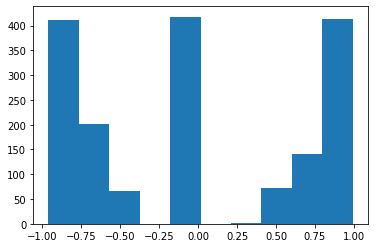

In [ ]:
plt.hist(dataset_analysis['bert'])


In [ ]:
dataset_analysis[['bert','vader','textblob','flair','Sentiment']].corr()

,bert,vader,textblob,flair,Sentiment
bert,1.000000,0.561206,0.434321,0.621531,0.818070
vader,0.561206,1.000000,0.526156,0.397475,0.455666
textblob,0.434321,0.526156,1.000000,0.333892,0.315555
flair,0.621531,0.397475,0.333892,1.000000,0.555233
Sentiment,0.818070,0.455666,0.315555,0.555233,1.000000


In [ ]:
dataset_analysis['vader_polarity'] = dataset_analysis.apply(lambda x: polarity(x['vader']), axis=1)
dataset_analysis['textblob_polarity'] = dataset_analysis.apply(lambda x: polarity(x['textblob']), axis=1)
dataset_analysis['bert_polarity'] = dataset_analysis.apply(lambda x: polarity(x['bert']), axis=1)
dataset_analysis['flair_polarity'] = dataset_analysis.apply(lambda x: polarity(x['flair']), axis=1)

In [ ]:
dataset_analysis[['bert_polarity','vader_polarity','textblob_polarity','flair_polarity','Sentiment']].corr()

,bert_polarity,vader_polarity,textblob_polarity,flair_polarity,Sentiment
bert_polarity,1.000000,0.503959,0.299322,0.481782,0.767355
vader_polarity,0.503959,1.000000,0.366808,0.339412,0.448164
textblob_polarity,0.299322,0.366808,1.000000,0.225745,0.273873
flair_polarity,0.481782,0.339412,0.225745,1.000000,0.528256
Sentiment,0.767355,0.448164,0.273873,0.528256,1.000000


In [ ]:
dataset_analysis.to_csv('semeval_test_results.csv')

# START HERE in case u want to use the saved data

In [18]:
dataset_analysis = pd.read_csv('semeval_test_results.csv')

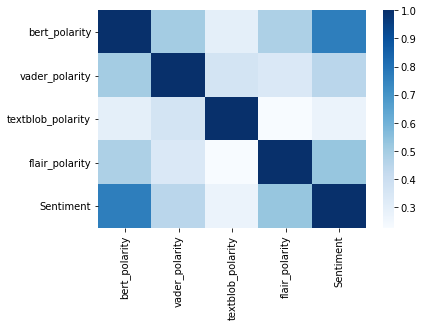

In [19]:
cordata = pd.DataFrame(dataset_analysis[['bert_polarity','vader_polarity','textblob_polarity','flair_polarity','Sentiment']].corr())
cordata.to_csv('semeval_corrdata.csv')
sns.heatmap (cordata,cmap='Blues')

In [20]:
dataset_analysis = dataset_analysis[(dataset_analysis['vader'] != 0) |
                   (dataset_analysis['textblob'] != 0) |
                   (dataset_analysis['bert'] != 0) |
                   (dataset_analysis['flair'] != 0) ]



In [21]:
dataset_analysis[['vader','textblob','bert','flair','Sentiment']].corr()




,vader,textblob,bert,flair,Sentiment
vader,1.000000,0.526156,0.561206,0.397475,0.455666
textblob,0.526156,1.000000,0.434321,0.333892,0.315555
bert,0.561206,0.434321,1.000000,0.621531,0.818070
flair,0.397475,0.333892,0.621531,1.000000,0.555233
Sentiment,0.455666,0.315555,0.818070,0.555233,1.000000


In [22]:
from sklearn import metrics
from sklearn.metrics import classification_report

#


### Vader

              precision    recall  f1-score   support

          -1       0.84      0.51      0.64       863
           1       0.65      0.90      0.75       863

    accuracy                           0.71      1726
   macro avg       0.74      0.71      0.70      1726
weighted avg       0.74      0.71      0.70      1726



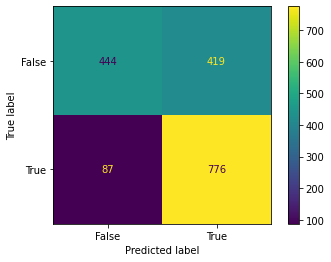

In [23]:
print(classification_report(dataset_analysis['Sentiment'],dataset_analysis['vader_polarity'])) # 
confusion_matrix_vader = metrics.confusion_matrix(dataset_analysis['Sentiment'], dataset_analysis['vader_polarity'])
cm_bert = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_vader, display_labels = [False, True])
cm_bert.plot()
plt.show()

### Textblob

              precision    recall  f1-score   support

          -1       0.74      0.36      0.49       863
           1       0.58      0.87      0.70       863

    accuracy                           0.62      1726
   macro avg       0.66      0.62      0.59      1726
weighted avg       0.66      0.62      0.59      1726



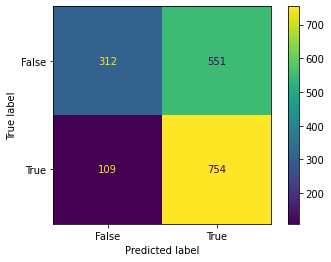

In [24]:
print(classification_report(dataset_analysis['Sentiment'],dataset_analysis['textblob_polarity'])) # 
confusion_matrix_tb = metrics.confusion_matrix(dataset_analysis['Sentiment'], dataset_analysis['textblob_polarity'])
cm_tb = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_tb, display_labels = [False, True])
cm_tb.plot()
plt.show()

### Bert

              precision    recall  f1-score   support

          -1       0.98      0.77      0.86       863
           1       0.81      0.98      0.89       863

    accuracy                           0.87      1726
   macro avg       0.89      0.87      0.87      1726
weighted avg       0.89      0.87      0.87      1726



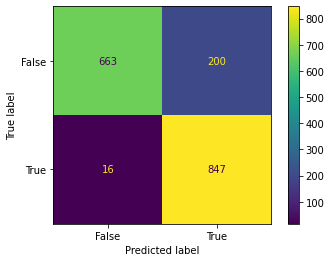

In [25]:
print(classification_report(dataset_analysis['Sentiment'],dataset_analysis['bert_polarity'])) # 
confusion_matrix_bert = metrics.confusion_matrix(dataset_analysis['Sentiment'], dataset_analysis['bert_polarity'])
cm_bert = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_bert, display_labels = [False, True])
cm_bert.plot()
plt.show()

### Flair

              precision    recall  f1-score   support

          -1       0.73      0.83      0.78       863
           1       0.81      0.69      0.74       863

    accuracy                           0.76      1726
   macro avg       0.77      0.76      0.76      1726
weighted avg       0.77      0.76      0.76      1726



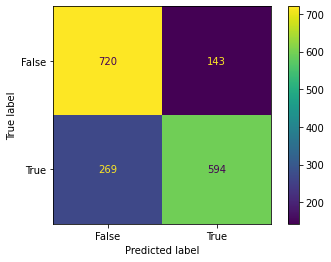

In [26]:
print(classification_report(dataset_analysis['Sentiment'],dataset_analysis['flair_polarity'])) # 
confusion_matrix_flair = metrics.confusion_matrix(dataset_analysis['Sentiment'], dataset_analysis['flair_polarity'])
cm_flair = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_flair, display_labels = [False, True])
cm_flair.plot()
plt.show()

### Data analysis

In [27]:

dataset_analysis = pd.read_csv('semeval_test_results.csv')



In [28]:
dataset_analysis['Sentiment'].value_counts()
## This is a skewed dataset
# Therefore Precision - Recall curve will be bette than the ROC curve in this case

-1    863
 1    863
Name: Sentiment, dtype: int64

(array([863.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 863.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <a list of 10 Patch objects>)

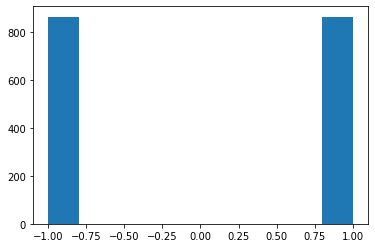

In [29]:
plt.hist(dataset_analysis['Sentiment'])

## Training and Testing using Logistic Regressor

### Training and Checking 

In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler


In [31]:
mmscaler = MinMaxScaler()

In [32]:
logmodel = LogisticRegression()


In [33]:

our_data=dataset_analysis



In [34]:
our_data.head()

,Unnamed: 0,0,Sentiment,Headline,vader,textblob,bert,flair,vader_polarity,textblob_polarity,bert_polarity,flair_polarity
0,0,6.415540e+17,-1,@foxandfriends Hillary is sorry now that she ...,-0.7003,-0.450000,-0.783502,-0.739876,-1,-1,-1,-1
1,1,6.405250e+17,1,"well Migos, Fetty Wap, Omarian, Kid Ink, Augus...",0.2732,0.050000,0.872306,0.906453,1,1,1,1
2,2,6.414260e+17,-1,When you have 3 1/2 tests tomorrow and a lab t...,-0.4703,0.325000,-0.882527,-0.826219,-1,1,-1,-1
3,3,6.360680e+17,1,The best part of living in New York is the nig...,0.8910,0.427273,0.963640,0.995310,1,1,1,1
4,4,6.412510e+17,1,Tomorrow is 80s day and I don't wanna be the b...,0.0000,0.000000,0.000000,0.996199,1,1,1,1


In [35]:
X = our_data[['textblob','vader','bert','flair','vader_polarity','textblob_polarity','bert_polarity','flair_polarity','Sentiment']]
y = our_data['Sentiment']
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3)

In [38]:
y_test.shape



(518,)

In [39]:
X_train

,textblob,vader,bert,flair,vader_polarity,textblob_polarity,bert_polarity,flair_polarity,Sentiment
1690,-1.000000,-0.7430,-0.817780,-0.999985,-1,-1,-1,-1,-1
1391,-0.500000,-0.2732,-0.876993,-0.998666,-1,-1,-1,-1,-1
1013,-0.479167,0.1007,-0.857221,-0.999990,1,-1,-1,-1,-1
118,0.100000,0.6124,0.000000,-0.957165,1,1,1,-1,-1
1552,-0.750000,-0.6124,-0.776952,-0.999959,-1,-1,-1,-1,-1
...,...,...,...,...,...,...,...,...,...
864,0.000000,0.0772,-0.787394,-0.716729,1,1,-1,-1,-1
1065,0.300000,0.6369,0.983923,0.998600,1,1,1,1,1
507,0.142857,-0.4215,-0.721558,-0.999552,-1,1,-1,-1,-1
1149,0.123810,-0.3182,0.836495,0.978245,-1,1,1,1,1


In [136]:
X_train_full = X_train
X_train = X_train [['vader','textblob','bert','flair']]
X_train = mmscaler.fit_transform(X_train)

/Users/amitobe/opt/anaconda3/envs/nlp_course/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [137]:
X_train

array([[9.44352558e-02, 0.00000000e+00, 7.35319837e-02, 6.37789619e-06],
       [3.45088833e-01, 2.50000000e-01, 4.32310580e-02, 6.65983497e-04],
       [5.44576642e-01, 2.60416667e-01, 5.33490269e-02, 4.11284895e-06],
       ...,
       [2.65965961e-01, 5.71428571e-01, 1.22771747e-01, 2.22958137e-04],
       [3.21079870e-01, 5.61904762e-01, 9.20070480e-01, 9.89152242e-01],
       [2.56575788e-01, 4.75000000e-01, 1.30970052e-02, 4.69699271e-05]])

In [41]:
X_test_full = X_test
X_test = X_test [['vader','textblob','bert','flair']]
X_test = mmscaler.fit_transform(X_test)


In [42]:


logmodel.fit(X_train,y_train) # Outputs are -1 and 1

LogisticRegression()

In [43]:
X_train

array([[9.44352558e-02, 0.00000000e+00, 7.35319837e-02, 6.37789619e-06],
       [3.45088833e-01, 2.50000000e-01, 4.32310580e-02, 6.65983497e-04],
       [5.44576642e-01, 2.60416667e-01, 5.33490269e-02, 4.11284895e-06],
       ...,
       [2.65965961e-01, 5.71428571e-01, 1.22771747e-01, 2.22958137e-04],
       [3.21079870e-01, 5.61904762e-01, 9.20070480e-01, 9.89152242e-01],
       [2.56575788e-01, 4.75000000e-01, 1.30970052e-02, 4.69699271e-05]])

In [44]:
predictions = logmodel.predict(X_train)
probs = logmodel.predict_proba(X_train)


In [45]:
xx =pd.DataFrame([{'vader':.8,'textblob':.4,'bert':.8,'flair':.62}])
tem = logmodel.predict_proba(xx)
tem



/Users/amitobe/opt/anaconda3/envs/nlp_course/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


array([[0.05305713, 0.94694287]])

In [46]:
probs.shape




(1208, 2)

In [47]:

probsdf = pd.DataFrame(probs)
probsdf['trth'] = y_train.to_numpy()
#aplha = 0.80
#high_prob_data = probsdf[(probsdf[1] > aplha) | (probsdf[0] > aplha)]
#probsdf = high_prob_data
probsdf.shape


(1208, 3)

### ROC Curve Analysis

In [48]:
import matplotlib
import matplotlib.pyplot as pyplot

Logistic: ROC AUC=0.962


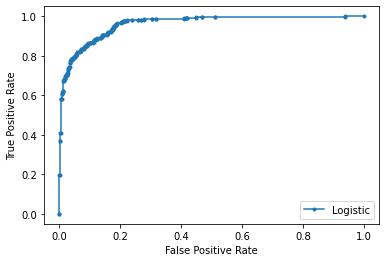

In [49]:
lr_probs = probs[:,[1]]
lr_auc = roc_auc_score(y_train, lr_probs)
# summarize scores

print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves

lr_fpr, lr_tpr, thr = roc_curve(y_train, lr_probs)
# plot the roc curve for the model # pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [50]:
optimal_idx = np.argmax(lr_tpr - lr_fpr) #we need to maximise TP-FP
thr[optimal_idx]

0.41859062174299927

In [51]:
alpha_thresh = thr[optimal_idx]

def label_pol (prob_score):
    
    if prob_score[1] > alpha_thresh:
        return 1
    else:
       return -1


In [52]:
probsdf['label_pol_pred'] = probsdf.apply (lambda row: label_pol(row), axis=1)
probsdf.head()



,0,1,trth,label_pol_pred
0,0.965628,0.034372,-1,-1
1,0.969696,0.030304,-1,-1
2,0.960974,0.039026,-1,-1
3,0.494135,0.505865,-1,1
4,0.960804,0.039196,-1,-1


In [53]:
from sklearn import metrics
print(pd.DataFrame(metrics.classification_report(probsdf['trth'],probsdf['label_pol_pred'],output_dict=True)))




                   -1           1  accuracy    macro avg  weighted avg
precision    0.956863    0.836676  0.887417     0.896769      0.896570
recall       0.810631    0.963696  0.887417     0.887164      0.887417
f1-score     0.877698    0.895706  0.887417     0.886702      0.886731
support    602.000000  606.000000  0.887417  1208.000000   1208.000000



### Data Capture Threshold Analysis

In [54]:
threshold_analysis = pd.DataFrame({'Thresh_alpha':[0],'Accuracy':[0],'Percent_data_capture':[0],'Precision':[0],'Recall':[0],'f1':[0]})
detl_threshold = pd.DataFrame({'Thresh_alpha':[],'Accuracy':[],'Percent_data_capture':[],'Precision':[],'Recall':[],'f1':[]})
for i in range (4,92):
    alpha_th = i*.01
    res1 = pd.DataFrame(classification_report(probsdf['trth'][(probsdf[1]>alpha_th)|(probsdf[0]>alpha_th)],probsdf['label_pol_pred'][(probsdf[1]>alpha_th)|(probsdf[0]>alpha_th)],output_dict=True))
    threshold_analysis['Accuracy']= res1['accuracy'].iloc[0]
    threshold_analysis['Percent_data_capture'] = probsdf['trth'][(probsdf[1]>alpha_th)|(probsdf[0]>alpha_th)].count()/probsdf['trth'].count()
    threshold_analysis['Thresh_alpha'] = alpha_th
    threshold_analysis['Precision'] = res1['1'].loc['precision']
    threshold_analysis['Recall'] = res1['1'].loc['recall']
    threshold_analysis['f1'] = res1['1'].loc['f1-score']
    detl_threshold = detl_threshold.append(threshold_analysis)

In [55]:
res1

,-1,1,accuracy,macro avg,weighted avg
precision,0.982456,0.979849,0.981156,0.981153,0.981159
recall,0.980000,0.982323,0.981156,0.981162,0.981156
f1-score,0.981227,0.981084,0.981156,0.981156,0.981156
support,400.000000,396.000000,0.981156,796.000000,796.000000


In [56]:
detl_threshold.head()

,Thresh_alpha,Accuracy,Percent_data_capture,Precision,Recall,f1
0,0.04,0.887417,1.0,0.836676,0.963696,0.895706
0,0.05,0.887417,1.0,0.836676,0.963696,0.895706
0,0.06,0.887417,1.0,0.836676,0.963696,0.895706
0,0.07,0.887417,1.0,0.836676,0.963696,0.895706
0,0.08,0.887417,1.0,0.836676,0.963696,0.895706


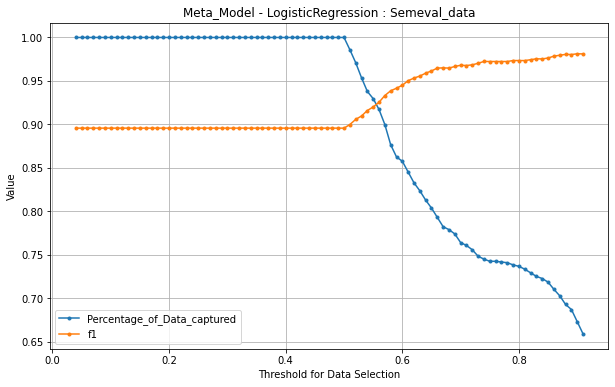

In [57]:
plt.rcParams['figure.figsize'] = [10, 6]
#pyplot.plot(detl_threshold['Thresh_alpha'], detl_threshold['Accuracy'], marker='.', label='Accuracy')
pyplot.plot(detl_threshold['Thresh_alpha'], detl_threshold['Percent_data_capture'], marker='.', label='Percentage_of_Data_captured')
#pyplot.plot(detl_threshold['Thresh_alpha'], detl_threshold['Precision'], marker='.', label='Precision')
#pyplot.plot(detl_threshold['Thresh_alpha'], detl_threshold['Recall'], marker='.', label='Recall')
pyplot.plot(detl_threshold['Thresh_alpha'], detl_threshold['f1'], marker='.', label='f1')
pyplot.xlabel('Threshold for Data Selection')
pyplot.ylabel('Value')
pyplot.grid(visible=True, which='both', axis='both')
#pyplot.grid(True)
pyplot.title('Meta_Model - LogisticRegression : Semeval_data')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()  # we find that doe data selection threshold of 0.78 we should have good results; tradeoof is that we would miss 65% of dta and look at only 35% of data points for an assured accuracy of 90% and f1 score of approx .8

In [58]:
np.unique(y_train,return_counts = True)  # we realise that the dataset is not balanced

(array([-1,  1]), array([602, 606]))

### We look at Precision Recall curve which is more promising since this dataset is imbalanced.

https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0118432

In [59]:
probsdf.head() # vector containing predicted prob for +1

,0,1,trth,label_pol_pred
0,0.965628,0.034372,-1,-1
1,0.969696,0.030304,-1,-1
2,0.960974,0.039026,-1,-1
3,0.494135,0.505865,-1,1
4,0.960804,0.039196,-1,-1


In [60]:
precision, recall, thresholds = sklearn.metrics.precision_recall_curve(y_train, probsdf[1])


In [61]:
auc_pr = sklearn.metrics.auc(recall,precision)
auc_pr

0.9623049134223719

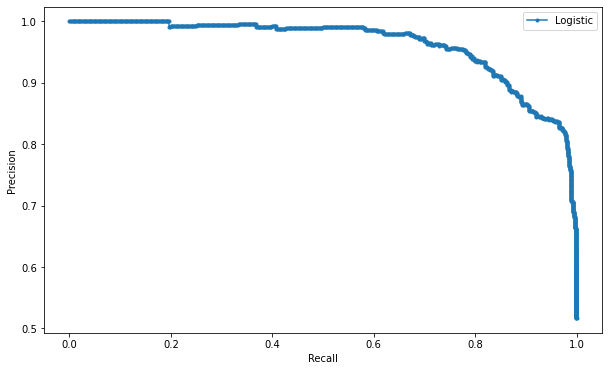

In [62]:
pyplot.plot(recall, precision, marker='.', label='Logistic')
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

## Model Test

In [63]:
#we now test the logistic regressor
X_test.shape

(518, 4)

In [64]:
predictions_test = logmodel.predict(X_test)
probs_test = logmodel.predict_proba(X_test)

Logistic: ROC AUC=0.961


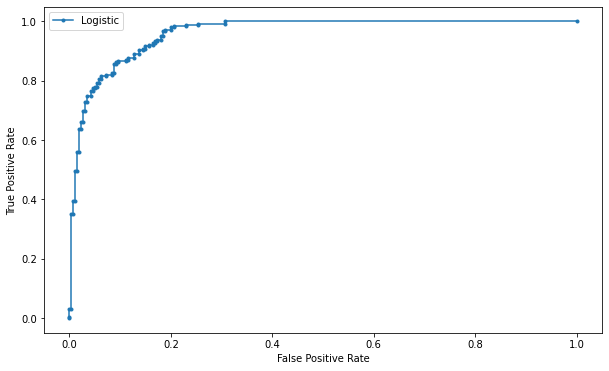

In [65]:
lr_probs = probs_test[:,[1]]
lr_auc = roc_auc_score(y_test, lr_probs)
# summarize scores

print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves

lr_fpr, lr_tpr, thr = roc_curve(y_test, lr_probs)
# plot the roc curve for the model # pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [66]:
optimal_idx = np.argmax(lr_tpr - lr_fpr) #we need to maximise TP-FP
thr[optimal_idx]

0.40795629307741266

In [67]:
alpha_thresh = thr[optimal_idx]

def label_pol (prob_score):
    
    if prob_score[1] > alpha_thresh:
        return 1
    else:
       return -1

In [68]:
probsdf_test = pd.DataFrame(probs_test)
probsdf_test['trth'] = y_test.to_numpy()
probsdf_test['label_pol_pred'] = probsdf_test.apply (lambda row: label_pol(row), axis=1)
probsdf_test.head()


,0,1,trth,label_pol_pred
0,0.581587,0.418413,1,1
1,0.960170,0.039830,-1,-1
2,0.583993,0.416007,1,1
3,0.971582,0.028418,-1,-1
4,0.023527,0.976473,1,1


In [69]:
print(pd.DataFrame(metrics.classification_report(probsdf_test['trth'],probsdf_test['label_pol_pred'],output_dict=True)))

                   -1           1  accuracy   macro avg  weighted avg
precision    0.963636    0.835570  0.889961    0.899603      0.900098
recall       0.812261    0.968872  0.889961    0.890566      0.889961
f1-score     0.881497    0.897297  0.889961    0.889397      0.889336
support    261.000000  257.000000  0.889961  518.000000    518.000000


In [70]:
probsdf_test[['trth','label_pol_pred']].corr()

,trth,label_pol_pred
trth,1.000000,0.790118
label_pol_pred,0.790118,1.000000


In [71]:
alpha_th_test = .7
probsdf_test['trth'][(probsdf_test[1]>alpha_th_test)|(probsdf_test[0]>alpha_th_test)].count()

411

In [72]:
print(pd.DataFrame(metrics.classification_report(probsdf_test['trth'][(probsdf_test[1]>alpha_th_test)|(probsdf_test[0]>alpha_th_test) ],probsdf_test['label_pol_pred'][(probsdf_test[1]>alpha_th_test)|(probsdf_test[0]>alpha_th_test)],output_dict=True)))

                   -1           1  accuracy   macro avg  weighted avg
precision    0.980952    0.955224   0.96837    0.968088      0.968683
recall       0.958140    0.979592   0.96837    0.968866      0.968370
f1-score     0.969412    0.967254   0.96837    0.968333      0.968383
support    215.000000  196.000000   0.96837  411.000000    411.000000


In [73]:
probsdf_test['trth'][(probsdf_test[1]>alpha_th)|(probsdf_test[0]>alpha_th)].count()/probsdf_test['trth'].count()

0.6891891891891891

In [74]:
test_results=pd.DataFrame({'Prob':[],'label_pol_predict':[]})
test_results['Prob'] = probsdf_test[1]
test_results['label_pol_pred'] = probsdf_test['label_pol_pred']

### We need to analyse sentences
#### Also we need to compare with the four Base Models /  Tools

In [75]:
result_base_tools_tb = pd.DataFrame(metrics.classification_report(X_test_full['Sentiment'],X_test_full['textblob_polarity'],output_dict=True))

In [76]:
result_base_tools_vader = pd.DataFrame(metrics.classification_report(X_test_full['Sentiment'],X_test_full['vader_polarity'],output_dict=True))

In [77]:
result_base_tools_bert = pd.DataFrame(metrics.classification_report(X_test_full['Sentiment'],X_test_full['bert_polarity'],output_dict=True))

In [78]:
result_base_tools_flair = pd.DataFrame(metrics.classification_report(X_test_full['Sentiment'],X_test_full['flair_polarity'],output_dict=True))

In [79]:
result_base_tools_tb

,-1,1,accuracy,macro avg,weighted avg
precision,0.748031,0.575448,0.617761,0.661740,0.662406
recall,0.363985,0.875486,0.617761,0.619736,0.617761
f1-score,0.489691,0.694444,0.617761,0.592068,0.591277
support,261.000000,257.000000,0.617761,518.000000,518.000000


In [80]:
result_base_tools_vader

,-1,1,accuracy,macro avg,weighted avg
precision,0.865385,0.651934,0.716216,0.758659,0.759483
recall,0.517241,0.918288,0.716216,0.717765,0.716216
f1-score,0.647482,0.762520,0.716216,0.705001,0.704557
support,261.000000,257.000000,0.716216,518.000000,518.000000


In [81]:
result_base_tools_bert

,-1,1,accuracy,macro avg,weighted avg
precision,0.980952,0.821429,0.8861,0.901190,0.901806
recall,0.789272,0.984436,0.8861,0.886854,0.886100
f1-score,0.874735,0.895575,0.8861,0.885155,0.885074
support,261.000000,257.000000,0.8861,518.000000,518.000000


In [82]:
result_base_tools_flair

,-1,1,accuracy,macro avg,weighted avg
precision,0.730640,0.800905,0.760618,0.765772,0.765501
recall,0.831418,0.688716,0.760618,0.760067,0.760618
f1-score,0.777778,0.740586,0.760618,0.759182,0.759325
support,261.000000,257.000000,0.760618,518.000000,518.000000


In [83]:
probsdf_test[['tb','vader','bert','flair','textblob_polarity','vader_polarity','bert_polarity','flair_polarity'	]] = X_test_full[['vader','vader','bert','flair','textblob_polarity','vader_polarity','bert_polarity','flair_polarity']].to_numpy()

In [84]:
probsdf_test

,0,1,trth,label_pol_pred,tb,vader,bert,flair,textblob_polarity,vader_polarity,bert_polarity,flair_polarity
0,0.581587,0.418413,1,1,0.0000,0.0000,0.000000,-0.998799,1.0,1.0,1.0,-1.0
1,0.960170,0.039830,-1,-1,-0.0258,-0.0258,-0.737471,-0.994933,1.0,-1.0,-1.0,-1.0
2,0.583993,0.416007,1,1,0.0129,0.0129,0.000000,-0.755804,1.0,1.0,1.0,-1.0
3,0.971582,0.028418,-1,-1,-0.5334,-0.5334,-0.806515,-0.981972,1.0,-1.0,-1.0,-1.0
4,0.023527,0.976473,1,1,0.5859,0.5859,0.758257,0.969718,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
513,0.973946,0.026054,-1,-1,-0.3612,-0.3612,-0.876151,-0.998469,-1.0,-1.0,-1.0,-1.0
514,0.979776,0.020224,-1,-1,-0.4003,-0.4003,-0.952544,-0.998901,-1.0,-1.0,-1.0,-1.0
515,0.966139,0.033861,-1,-1,-0.4158,-0.4158,-0.804400,-0.935471,-1.0,-1.0,-1.0,-1.0
516,0.973574,0.026426,-1,-1,0.3818,0.3818,-0.934049,-0.999993,1.0,1.0,-1.0,-1.0


In [85]:
abs(probsdf_test['vader']).describe()

count    518.000000
mean       0.381878
std        0.290778
min        0.000000
25%        0.077200
50%        0.388800
75%        0.624900
max        0.963300
Name: vader, dtype: float64

In [86]:
alpha_th_test = .48
pd.DataFrame(metrics.classification_report(probsdf_test['trth'][abs(probsdf_test['vader'])>alpha_th_test],probsdf_test['vader_polarity'][abs(probsdf_test['vader'])>alpha_th_test],output_dict=True))

,-1,1,accuracy,macro avg,weighted avg
precision,0.942857,0.757576,0.821782,0.850216,0.847465
recall,0.673469,0.961538,0.821782,0.817504,0.821782
f1-score,0.785714,0.847458,0.821782,0.816586,0.817503
support,98.000000,104.000000,0.821782,202.000000,202.000000


In [87]:
abs(probsdf_test['bert']).describe()

count    518.000000
mean       0.626858
std        0.358189
min        0.000000
25%        0.523107
50%        0.769915
75%        0.902602
max        0.992722
Name: bert, dtype: float64

In [88]:
alpha_th_test = .78
res2 =pd.DataFrame(metrics.classification_report(probsdf_test['trth'][abs(probsdf_test['bert'])>alpha_th_test],probsdf_test['label_pol_pred'][abs(probsdf_test['bert'])>alpha_th_test],output_dict=True))
res2

,-1,1,accuracy,macro avg,weighted avg
precision,1.000000,0.96800,0.983936,0.984000,0.984450
recall,0.968750,1.00000,0.983936,0.984375,0.983936
f1-score,0.984127,0.98374,0.983936,0.983933,0.983939
support,128.000000,121.00000,0.983936,249.000000,249.000000


In [89]:
try:
    res2['1']
except KeyError:
    0

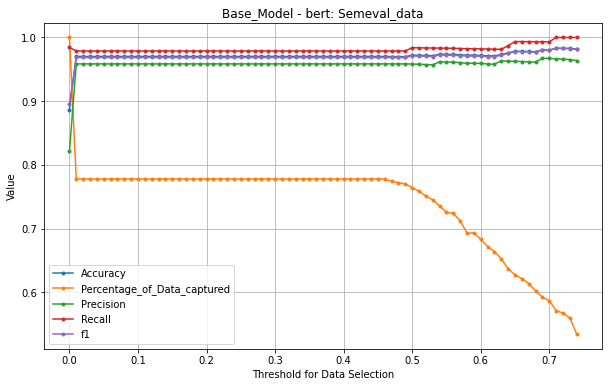

In [90]:
threshold_analysis = pd.DataFrame({'Thresh_alpha':[0],'Accuracy':[0],'Percent_data_capture':[0],'Precision':[0],'Recall':[0],'f1':[0]})
detl_threshold = pd.DataFrame({'Thresh_alpha':[],'Accuracy':[],'Percent_data_capture':[],'Precision':[],'Recall':[],'f1':[]})
for i in range (0,75):
    alpha_th = i*.01
    res1 = pd.DataFrame(classification_report(probsdf_test['trth'][abs(probsdf_test['bert'])>=alpha_th],probsdf_test['bert_polarity'][abs(probsdf_test['bert'])>=alpha_th],output_dict=True))
    threshold_analysis['Accuracy']= res1['accuracy'].loc['precision']
    threshold_analysis['Percent_data_capture'] =  probsdf_test['trth'][abs(probsdf_test['bert'])>=alpha_th].count()/probsdf_test['trth'].count() if  probsdf_test['trth'].count()>0 else 0
    threshold_analysis['Thresh_alpha'] = alpha_th
    try:
        threshold_analysis['Precision'] = res1['1'].loc['precision']
    except KeyError:
        threshold_analysis['Precision']=0
    try:
        threshold_analysis['Recall'] = res1['1'].loc['recall']
    except KeyError:
       threshold_analysis['Recall'] =0
    try:
        threshold_analysis['f1'] = res1['1'].loc['f1-score']
    except KeyError:
        threshold_analysis['f1'] 
    detl_threshold = detl_threshold.append(threshold_analysis)

plt.rcParams['figure.figsize'] = [10, 6]
pyplot.plot(detl_threshold['Thresh_alpha'], detl_threshold['Accuracy'], marker='.', label='Accuracy')
pyplot.plot(detl_threshold['Thresh_alpha'], detl_threshold['Percent_data_capture'], marker='.', label='Percentage_of_Data_captured')
pyplot.plot(detl_threshold['Thresh_alpha'], detl_threshold['Precision'], marker='.', label='Precision')
pyplot.plot(detl_threshold['Thresh_alpha'], detl_threshold['Recall'], marker='.', label='Recall')
pyplot.plot(detl_threshold['Thresh_alpha'], detl_threshold['f1'], marker='.', label='f1')
pyplot.xlabel('Threshold for Data Selection')
pyplot.ylabel('Value')
pyplot.grid(visible=True, which='both', axis='both')
#pyplot.grid(True)
pyplot.title('Base_Model - bert: Semeval_data')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

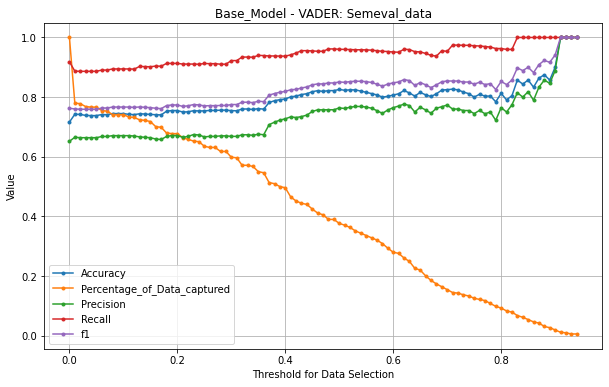

In [91]:
threshold_analysis = pd.DataFrame({'Thresh_alpha':[0],'Accuracy':[0],'Percent_data_capture':[0],'Precision':[0],'Recall':[0],'f1':[0]})
detl_threshold = pd.DataFrame({'Thresh_alpha':[],'Accuracy':[],'Percent_data_capture':[],'Precision':[],'Recall':[],'f1':[]})
for i in range (0,95):
    alpha_th = i*.01
    res1 = pd.DataFrame(classification_report(probsdf_test['trth'][abs(probsdf_test['vader'])>=alpha_th],probsdf_test['vader_polarity'][abs(probsdf_test['vader'])>=alpha_th],output_dict=True))
    threshold_analysis['Accuracy']= res1['accuracy'].iloc[0]
    threshold_analysis['Percent_data_capture'] = probsdf_test['trth'][abs(probsdf_test['vader'])>=alpha_th].count()/probsdf_test['trth'].count()
    threshold_analysis['Thresh_alpha'] = alpha_th
    try:
        threshold_analysis['Precision'] = res1['1'].loc['precision']
        threshold_analysis['Recall'] = res1['1'].loc['recall']
        threshold_analysis['f1'] = res1['1'].loc['f1-score']
    except KeyError:
        threshold_analysis['Precision'] = 0
        threshold_analysis['Recall'] = 0
        threshold_analysis['f1'] = 0
    detl_threshold = detl_threshold.append(threshold_analysis)

plt.rcParams['figure.figsize'] = [10, 6]
pyplot.plot(detl_threshold['Thresh_alpha'], detl_threshold['Accuracy'], marker='.', label='Accuracy')
pyplot.plot(detl_threshold['Thresh_alpha'], detl_threshold['Percent_data_capture'], marker='.', label='Percentage_of_Data_captured')
pyplot.plot(detl_threshold['Thresh_alpha'], detl_threshold['Precision'], marker='.', label='Precision')
pyplot.plot(detl_threshold['Thresh_alpha'], detl_threshold['Recall'], marker='.', label='Recall')
pyplot.plot(detl_threshold['Thresh_alpha'], detl_threshold['f1'], marker='.', label='f1')
pyplot.xlabel('Threshold for Data Selection')
pyplot.ylabel('Value')
pyplot.grid(visible=True, which='both', axis='both')
#pyplot.grid(True)
pyplot.title('Base_Model - VADER: Semeval_data')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

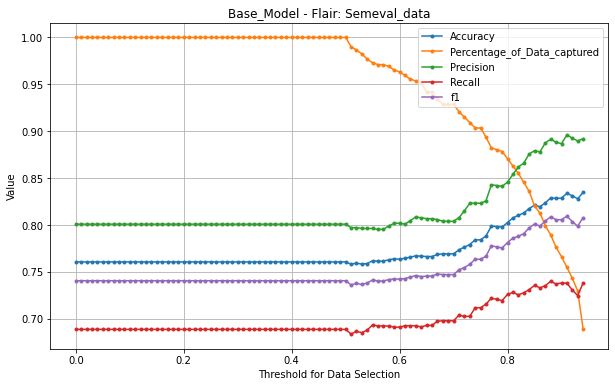

In [92]:
threshold_analysis = pd.DataFrame({'Thresh_alpha':[0],'Accuracy':[0],'Percent_data_capture':[0],'Precision':[0],'Recall':[0],'f1':[0]})
detl_threshold = pd.DataFrame({'Thresh_alpha':[],'Accuracy':[],'Percent_data_capture':[],'Precision':[],'Recall':[],'f1':[]})
for i in range (0,95):
    alpha_th = i*.01
    res1 = pd.DataFrame(classification_report(probsdf_test['trth'][abs(probsdf_test['flair'])>=alpha_th],probsdf_test['flair_polarity'][abs(probsdf_test['flair'])>=alpha_th],output_dict=True))
    threshold_analysis['Accuracy']= res1['accuracy'].iloc[0]
    threshold_analysis['Percent_data_capture'] = probsdf_test['trth'][abs(probsdf_test['flair'])>=alpha_th].count()/probsdf_test['trth'].count()
    threshold_analysis['Thresh_alpha'] = alpha_th
    try:
        threshold_analysis['Precision'] = res1['1'].loc['precision']
        threshold_analysis['Recall'] = res1['1'].loc['recall']
        threshold_analysis['f1'] = res1['1'].loc['f1-score']
    except KeyError:
        threshold_analysis['Precision'] = 0
        threshold_analysis['Recall'] = 0
        threshold_analysis['f1'] = 0
    detl_threshold = detl_threshold.append(threshold_analysis)

plt.rcParams['figure.figsize'] = [10, 6]
pyplot.plot(detl_threshold['Thresh_alpha'], detl_threshold['Accuracy'], marker='.', label='Accuracy')
pyplot.plot(detl_threshold['Thresh_alpha'], detl_threshold['Percent_data_capture'], marker='.', label='Percentage_of_Data_captured')
pyplot.plot(detl_threshold['Thresh_alpha'], detl_threshold['Precision'], marker='.', label='Precision')
pyplot.plot(detl_threshold['Thresh_alpha'], detl_threshold['Recall'], marker='.', label='Recall')
pyplot.plot(detl_threshold['Thresh_alpha'], detl_threshold['f1'], marker='.', label='f1')
pyplot.xlabel('Threshold for Data Selection')
pyplot.ylabel('Value')
pyplot.grid(visible=True, which='both', axis='both')
#pyplot.grid(True)
pyplot.title('Base_Model - Flair: Semeval_data')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

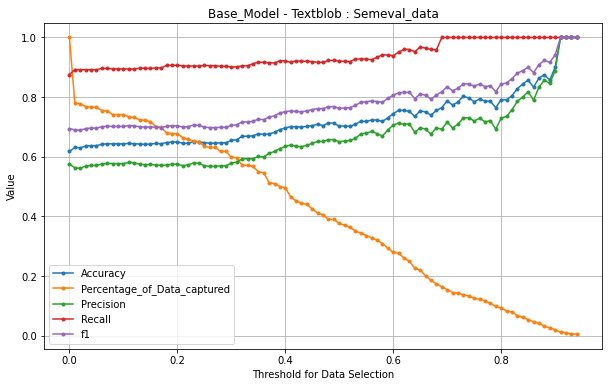

In [93]:
threshold_analysis = pd.DataFrame({'Thresh_alpha':[0],'Accuracy':[0],'Percent_data_capture':[0],'Precision':[0],'Recall':[0],'f1':[0]})
detl_threshold = pd.DataFrame({'Thresh_alpha':[],'Accuracy':[],'Percent_data_capture':[],'Precision':[],'Recall':[],'f1':[]})
for i in range (0,95):
    alpha_th = i*.01
    res1 = pd.DataFrame(classification_report(probsdf_test['trth'][abs(probsdf_test['tb'])>=alpha_th],probsdf_test['textblob_polarity'][abs(probsdf_test['tb'])>=alpha_th],output_dict=True))
    threshold_analysis['Accuracy']= res1['accuracy'].iloc[0]
    threshold_analysis['Percent_data_capture'] = probsdf_test['trth'][abs(probsdf_test['tb'])>=alpha_th].count()/probsdf_test['trth'].count()
    threshold_analysis['Thresh_alpha'] = alpha_th
    try:
        threshold_analysis['Precision'] = res1['1'].loc['precision']
        threshold_analysis['Recall'] = res1['1'].loc['recall']
        threshold_analysis['f1'] = res1['1'].loc['f1-score']
    except KeyError:
        threshold_analysis['Precision'] = 0
        threshold_analysis['Recall'] = 0
        threshold_analysis['f1'] = 0
    detl_threshold = detl_threshold.append(threshold_analysis)

plt.rcParams['figure.figsize'] = [10, 6]
pyplot.plot(detl_threshold['Thresh_alpha'], detl_threshold['Accuracy'], marker='.', label='Accuracy')
pyplot.plot(detl_threshold['Thresh_alpha'], detl_threshold['Percent_data_capture'], marker='.', label='Percentage_of_Data_captured')
pyplot.plot(detl_threshold['Thresh_alpha'], detl_threshold['Precision'], marker='.', label='Precision')
pyplot.plot(detl_threshold['Thresh_alpha'], detl_threshold['Recall'], marker='.', label='Recall')
pyplot.plot(detl_threshold['Thresh_alpha'], detl_threshold['f1'], marker='.', label='f1')
pyplot.xlabel('Threshold for Data Selection')
pyplot.ylabel('Value')
pyplot.grid(visible=True, which='both', axis='both')
#pyplot.grid(True)
pyplot.title('Base_Model - Textblob : Semeval_data')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [94]:
probsdf_test

,0,1,trth,label_pol_pred,tb,vader,bert,flair,textblob_polarity,vader_polarity,bert_polarity,flair_polarity
0,0.581587,0.418413,1,1,0.0000,0.0000,0.000000,-0.998799,1.0,1.0,1.0,-1.0
1,0.960170,0.039830,-1,-1,-0.0258,-0.0258,-0.737471,-0.994933,1.0,-1.0,-1.0,-1.0
2,0.583993,0.416007,1,1,0.0129,0.0129,0.000000,-0.755804,1.0,1.0,1.0,-1.0
3,0.971582,0.028418,-1,-1,-0.5334,-0.5334,-0.806515,-0.981972,1.0,-1.0,-1.0,-1.0
4,0.023527,0.976473,1,1,0.5859,0.5859,0.758257,0.969718,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
513,0.973946,0.026054,-1,-1,-0.3612,-0.3612,-0.876151,-0.998469,-1.0,-1.0,-1.0,-1.0
514,0.979776,0.020224,-1,-1,-0.4003,-0.4003,-0.952544,-0.998901,-1.0,-1.0,-1.0,-1.0
515,0.966139,0.033861,-1,-1,-0.4158,-0.4158,-0.804400,-0.935471,-1.0,-1.0,-1.0,-1.0
516,0.973574,0.026426,-1,-1,0.3818,0.3818,-0.934049,-0.999993,1.0,1.0,-1.0,-1.0


In [95]:
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

In [96]:


# List of classifiers to evaluate
classifiers = [
    ('Logistic Regression', LogisticRegression()),
    ('Support Vector Machine', SVC()),
    ('Random Forest', RandomForestClassifier()),
    ('Naive Bayes', GaussianNB())
]

# Iterate over classifiers and evaluate using cross-validation
for name, classifier in classifiers:
    scores = cross_val_score(classifier, X_train, y_train, cv=5)
    mean_score = np.mean(scores)
    print(f"{name} Mean Accuracy: {mean_score:.4f}")

# Choose the best model based on cross-validation scores
best_classifier = max(classifiers, key=lambda x: np.mean(cross_val_score(x[1], X_train, y_train, cv=5)))[1]

# Train the best classifier on the full training set
best_classifier.fit(X_train, y_train)

# Test the model on the test set
y_pred = best_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Best Model Test Accuracy: {accuracy:.4f}")


Logistic Regression Mean Accuracy: 0.8808
Support Vector Machine Mean Accuracy: 0.8717
Random Forest Mean Accuracy: 0.8618
Naive Bayes Mean Accuracy: 0.8758
Best Model Test Accuracy: 0.8822


In [97]:
model_eval = pd.DataFrame({'Model':[],'Mean_Score':[]})

In [98]:
model_eval

,Model,Mean_Score


In [99]:
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
model_eval = pd.DataFrame({'Model':[],'Mean_Score':[]})

# List of classifiers to evaluate
classifiers = [
    ('Logistic Regression', LogisticRegression()),
    ('Support Vector Machine', SVC()),
    ('Random Forest', RandomForestClassifier()),
    ('Naive Bayes', GaussianNB()),
    ('Decision Tree', DecisionTreeClassifier()),
    ('Gradient Boosting', GradientBoostingClassifier()),
    ('AdaBoost', AdaBoostClassifier()),
    ('Ridge Classifier', RidgeClassifier())
]

# Iterate over classifiers and evaluate using cross-validation
for name, classifier in classifiers:
    scores = cross_val_score(classifier, X_train, y_train, cv=5)
    mean_score = np.mean(scores)
    scores_temp = pd.DataFrame({'Model':[name],'Mean_Score':[mean_score]})
    model_eval = model_eval.append(scores_temp)
    print(f"{name} Mean Accuracy: {mean_score:.4f}")

# Choose the best model based on cross-validation scores
best_classifier = max(classifiers, key=lambda x: np.mean(cross_val_score(x[1], X_train, y_train, cv=5)))[1]

# Train the best classifier on the full training set
best_classifier.fit(X_train, y_train)

# Test the model on the test set
y_pred = best_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Best Model Test Accuracy: {accuracy:.4f}")


Logistic Regression Mean Accuracy: 0.8808
Support Vector Machine Mean Accuracy: 0.8717
Random Forest Mean Accuracy: 0.8643
Naive Bayes Mean Accuracy: 0.8758
Decision Tree Mean Accuracy: 0.8444
Gradient Boosting Mean Accuracy: 0.8792
AdaBoost Mean Accuracy: 0.8626
Ridge Classifier Mean Accuracy: 0.8742
Best Model Test Accuracy: 0.8822


In [100]:
model_eval

,Model,Mean_Score
0,Logistic Regression,0.880796
0,Support Vector Machine,0.871699
0,Random Forest,0.864257
0,Naive Bayes,0.875824
0,Decision Tree,0.844388
0,Gradient Boosting,0.879154
0,AdaBoost,0.862601
0,Ridge Classifier,0.874178


In [101]:
best_classifier

LogisticRegression()

In [102]:

gb_classifier = GradientBoostingClassifier(n_estimators=150, learning_rate=0.01,random_state=42)
# Train the classifier on the training data
gb_classifier.fit(X_train, y_train)

# Make predictions on the test data
y_pred = gb_classifier.predict(X_test)

# Evaluate the classifier's performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Print the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))




Accuracy: 0.89
Classification Report:
              precision    recall  f1-score   support

          -1       0.88      0.90      0.89       261
           1       0.90      0.88      0.89       257

    accuracy                           0.89       518
   macro avg       0.89      0.89      0.89       518
weighted avg       0.89      0.89      0.89       518



In [103]:
y_probs = gb_classifier.predict_proba(X_train)
y_probs.shape

(1208, 2)

Logistic: ROC AUC=0.970


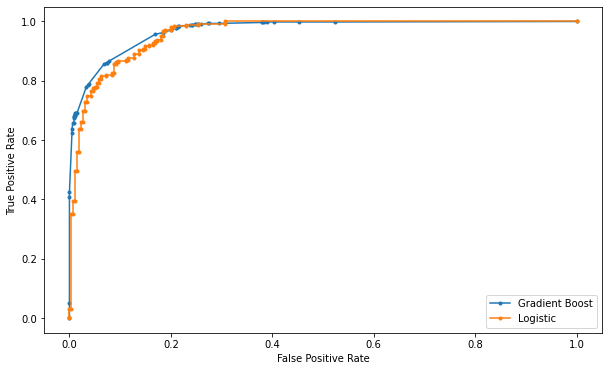

In [104]:
gb_probs = y_probs[:,[1]]
gb_auc = roc_auc_score(y_train, gb_probs)
# summarize scores

print('Logistic: ROC AUC=%.3f' % (gb_auc))
# calculate roc curves

gb_fpr, gb_tpr, thr = roc_curve(y_train, gb_probs)
# plot the roc curve for the model # pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(gb_fpr, gb_tpr, marker='.', label='Gradient Boost')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

Logistic: ROC AUC=0.962


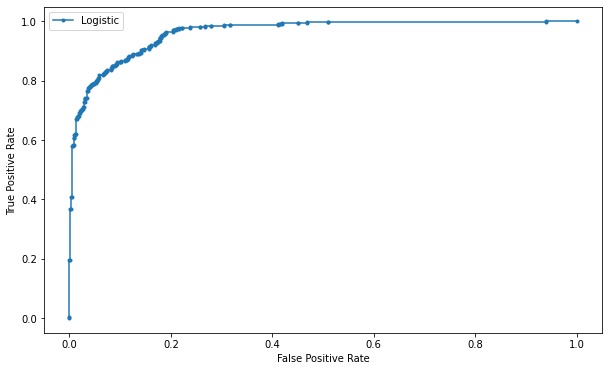

In [105]:
lr_probs = probs[:,[1]]
lr_auc = roc_auc_score(y_train, lr_probs)
# summarize scores

print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves

lr_fpr, lr_tpr, thr = roc_curve(y_train, lr_probs)
# plot the roc curve for the model # pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [106]:
y_probs = gb_classifier.predict_proba(X_test)

Logistic: ROC AUC=0.953


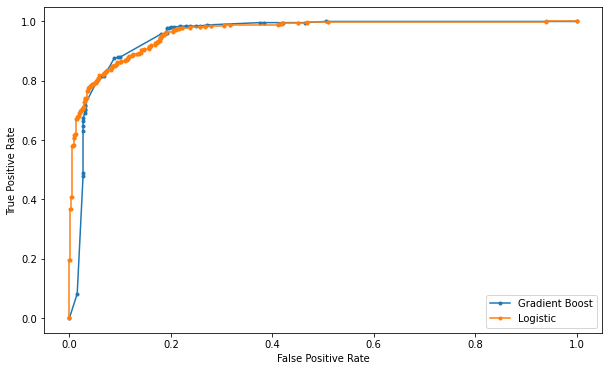

In [107]:
gb_probs = y_probs[:,[1]]
gb_auc = roc_auc_score(y_test, gb_probs)
# summarize scores

print('Logistic: ROC AUC=%.3f' % (gb_auc))
# calculate roc curves

gb_fpr, gb_tpr, thr = roc_curve(y_test, gb_probs)
# plot the roc curve for the model # pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(gb_fpr, gb_tpr, marker='.', label='Gradient Boost')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [108]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report

gb_classifier1 = GradientBoostingClassifier()

# Define a grid of hyperparameters to search
param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.1, 0.01],
    'max_depth': [3, 4, 5]
}

# Initialize GridSearchCV with the classifier and parameter grid
grid_search = GridSearchCV(gb_classifier1, param_grid, cv=3, scoring='accuracy')

# Perform hyperparameter tuning on the training data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters from the grid search
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Use the best model for prediction
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Evaluate the classifier's performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Print the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}
Accuracy: 0.90
Classification Report:
              precision    recall  f1-score   support

          -1       0.93      0.86      0.89       261
           1       0.87      0.93      0.90       257

    accuracy                           0.90       518
   macro avg       0.90      0.90      0.90       518
weighted avg       0.90      0.90      0.90       518



# Best Model Analysis
The best meta model was found to be GradientBoost. here after hyperparameter tuning we found the accuracy score to be 0.73
Now we will see if we can custom threshold and improve acuraccy.

In [109]:
probsdf_test['GBprobs_0']=gb_classifier.predict_proba(X_test)[:,0]
probsdf_test['GBprobs_1']=gb_classifier.predict_proba(X_test)[:,1]
probsdf_test.head()

,0,1,trth,label_pol_pred,tb,vader,bert,flair,textblob_polarity,vader_polarity,bert_polarity,flair_polarity,GBprobs_0,GBprobs_1
0,0.581587,0.418413,1,1,0.0000,0.0000,0.000000,-0.998799,1.0,1.0,1.0,-1.0,0.505568,0.494432
1,0.960170,0.039830,-1,-1,-0.0258,-0.0258,-0.737471,-0.994933,1.0,-1.0,-1.0,-1.0,0.880427,0.119573
2,0.583993,0.416007,1,1,0.0129,0.0129,0.000000,-0.755804,1.0,1.0,1.0,-1.0,0.367719,0.632281
3,0.971582,0.028418,-1,-1,-0.5334,-0.5334,-0.806515,-0.981972,1.0,-1.0,-1.0,-1.0,0.882273,0.117727
4,0.023527,0.976473,1,1,0.5859,0.5859,0.758257,0.969718,1.0,1.0,1.0,1.0,0.117424,0.882576


In [110]:
def Gb_polarity(val):
    if val >= 0.5:
        return 1
    else:
        return -1

In [111]:
probsdf_test['GBoost_polarity']= probsdf_test.apply (lambda x : Gb_polarity(x['GBprobs_1']),axis=1)
probsdf_test['GBoost_Pred']=gb_classifier.predict(X_test)

In [112]:
probsdf_test['trth1']=y_test

In [113]:
probsdf_test.head()

,0,1,trth,label_pol_pred,tb,vader,bert,flair,textblob_polarity,vader_polarity,bert_polarity,flair_polarity,GBprobs_0,GBprobs_1,GBoost_polarity,GBoost_Pred,trth1
0,0.581587,0.418413,1,1,0.0000,0.0000,0.000000,-0.998799,1.0,1.0,1.0,-1.0,0.505568,0.494432,-1,-1,NaN
1,0.960170,0.039830,-1,-1,-0.0258,-0.0258,-0.737471,-0.994933,1.0,-1.0,-1.0,-1.0,0.880427,0.119573,-1,-1,NaN
2,0.583993,0.416007,1,1,0.0129,0.0129,0.000000,-0.755804,1.0,1.0,1.0,-1.0,0.367719,0.632281,1,1,-1.0
3,0.971582,0.028418,-1,-1,-0.5334,-0.5334,-0.806515,-0.981972,1.0,-1.0,-1.0,-1.0,0.882273,0.117727,-1,-1,1.0
4,0.023527,0.976473,1,1,0.5859,0.5859,0.758257,0.969718,1.0,1.0,1.0,1.0,0.117424,0.882576,1,1,1.0


### Stacked Ensemble with Meta Model as LR : Semeval_data

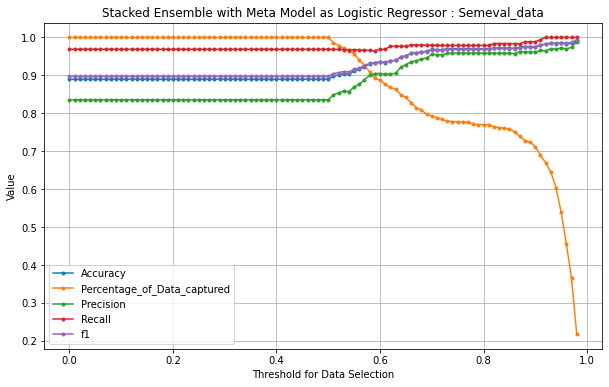

In [114]:

threshold_analysis = pd.DataFrame({'Thresh_alpha':[0],'Accuracy':[0],'Percent_data_capture':[0],'Precision':[0],'Recall':[0],'f1':[0]})
detl_threshold = pd.DataFrame({'Thresh_alpha':[],'Accuracy':[],'Percent_data_capture':[],'Precision':[],'Recall':[],'f1':[]})
for i in range (0,99):
    alpha_th = i*.01
    res1 = pd.DataFrame(classification_report(probsdf_test['trth'][(probsdf_test[0]>=alpha_th)|(probsdf_test[1]>=alpha_th)],probsdf_test['label_pol_pred'][(probsdf_test[0]>=alpha_th)|(probsdf_test[1]>=alpha_th)],output_dict=True))
    threshold_analysis['Accuracy']= res1['accuracy'].iloc[0]
    threshold_analysis['Percent_data_capture'] = probsdf_test['trth'][(probsdf_test[0]>=alpha_th)|(probsdf_test[1]>=alpha_th)].count()/probsdf_test[0].count()
    threshold_analysis['Thresh_alpha'] = alpha_th
    try:
        threshold_analysis['Precision'] = res1['1'].loc['precision']
        threshold_analysis['Recall'] = res1['1'].loc['recall']
        threshold_analysis['f1'] = res1['1'].loc['f1-score']
    except KeyError:
        threshold_analysis['Precision'] = 0
        threshold_analysis['Recall'] = 0
        threshold_analysis['f1'] = 0
    detl_threshold = detl_threshold.append(threshold_analysis)

plt.rcParams['figure.figsize'] = [10, 6]
pyplot.plot(detl_threshold['Thresh_alpha'], detl_threshold['Accuracy'], marker='.', label='Accuracy')
pyplot.plot(detl_threshold['Thresh_alpha'], detl_threshold['Percent_data_capture'], marker='.', label='Percentage_of_Data_captured')
pyplot.plot(detl_threshold['Thresh_alpha'], detl_threshold['Precision'], marker='.', label='Precision')
pyplot.plot(detl_threshold['Thresh_alpha'], detl_threshold['Recall'], marker='.', label='Recall')
pyplot.plot(detl_threshold['Thresh_alpha'], detl_threshold['f1'], marker='.', label='f1')
pyplot.xlabel('Threshold for Data Selection')
pyplot.ylabel('Value')
pyplot.grid(visible=True, which='both', axis='both')
#pyplot.grid(True)
pyplot.title('Stacked Ensemble with Meta Model as Logistic Regressor : Semeval_data')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

### Stacked Ensemble with Meta Model as GradientBoost : Semeval_data

/Users/amitobe/opt/anaconda3/envs/nlp_course/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/amitobe/opt/anaconda3/envs/nlp_course/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/amitobe/opt/anaconda3/envs/nlp_course/lib/python3.7/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/Users/amitobe/opt/anaconda3/envs/nlp_course/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = re

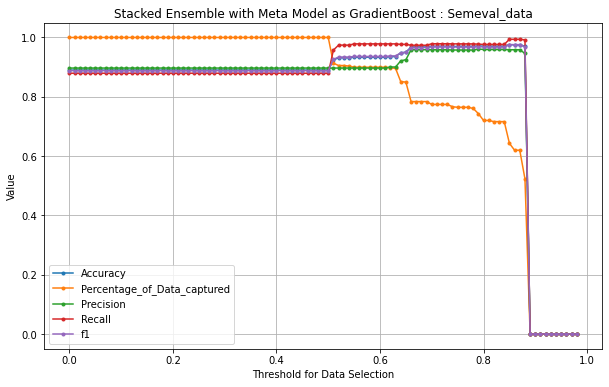

In [115]:
threshold_analysis = pd.DataFrame({'Thresh_alpha':[0],'Accuracy':[0],'Percent_data_capture':[0],'Precision':[0],'Recall':[0],'f1':[0]})
detl_threshold = pd.DataFrame({'Thresh_alpha':[],'Accuracy':[],'Percent_data_capture':[],'Precision':[],'Recall':[],'f1':[]})
for i in range (0,99):
    alpha_th = i*.01
    res1 = pd.DataFrame(classification_report(probsdf_test['trth'][(probsdf_test['GBprobs_1']>alpha_th) | (probsdf_test['GBprobs_0']>alpha_th)],probsdf_test['GBoost_Pred'][(probsdf_test['GBprobs_1']>alpha_th) | (probsdf_test['GBprobs_0']>alpha_th)],output_dict=True))
    threshold_analysis['Accuracy']= res1['accuracy'].iloc[0]
    threshold_analysis['Percent_data_capture'] = probsdf_test['trth'][(probsdf_test['GBprobs_1']>alpha_th) | (probsdf_test['GBprobs_0']>alpha_th)].count()/probsdf_test['GBprobs_1'].count()
    threshold_analysis['Thresh_alpha'] = alpha_th
    try:
        threshold_analysis['Precision'] = res1['1'].loc['precision']
        threshold_analysis['Recall'] = res1['1'].loc['recall']
        threshold_analysis['f1'] = res1['1'].loc['f1-score']
    except KeyError:
        threshold_analysis['Precision'] = 0
        threshold_analysis['Recall'] = 0
        threshold_analysis['f1'] = 0
    detl_threshold = detl_threshold.append(threshold_analysis)

plt.rcParams['figure.figsize'] = [10, 6]
pyplot.plot(detl_threshold['Thresh_alpha'], detl_threshold['Accuracy'], marker='.', label='Accuracy')
pyplot.plot(detl_threshold['Thresh_alpha'], detl_threshold['Percent_data_capture'], marker='.', label='Percentage_of_Data_captured')
pyplot.plot(detl_threshold['Thresh_alpha'], detl_threshold['Precision'], marker='.', label='Precision')
pyplot.plot(detl_threshold['Thresh_alpha'], detl_threshold['Recall'], marker='.', label='Recall')
pyplot.plot(detl_threshold['Thresh_alpha'], detl_threshold['f1'], marker='.', label='f1')
pyplot.xlabel('Threshold for Data Selection')
pyplot.ylabel('Value')
pyplot.grid(visible=True, which='both', axis='both')
#pyplot.grid(True)
pyplot.title('Stacked Ensemble with Meta Model as GradientBoost : Semeval_data')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [116]:
corr_analysis = probsdf_test[['label_pol_pred','GBoost_Pred','textblob_polarity','flair_polarity','vader_polarity','bert_polarity','trth']].corr()

In [117]:
probsdf_test[['label_pol_pred','GBoost_Pred','textblob_polarity','flair_polarity','vader_polarity','bert_polarity','trth']].corr().to_csv('semeval_final_corrdata.csv')

(array([181.,  12.,   8.,  40.,   8.,  50.,   9.,   4.,  12., 194.]),
 array([0.00892245, 0.10650714, 0.20409183, 0.30167652, 0.39926122,
        0.49684591, 0.5944306 , 0.69201529, 0.78959998, 0.88718467,
        0.98476936]),
 <a list of 10 Patch objects>)

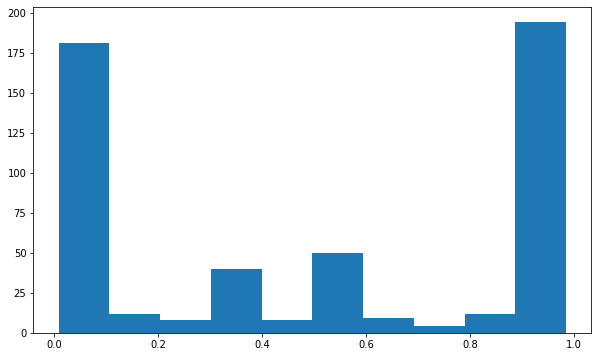

In [118]:
plt.hist(probsdf_test[0])

(array([173.,  20.,  34.,  25.,   0.,  52.,   1.,   5.,   8., 200.]),
 array([0.11718019, 0.19368951, 0.27019884, 0.34670816, 0.42321749,
        0.49972681, 0.57623614, 0.65274546, 0.72925479, 0.80576411,
        0.88227343]),
 <a list of 10 Patch objects>)

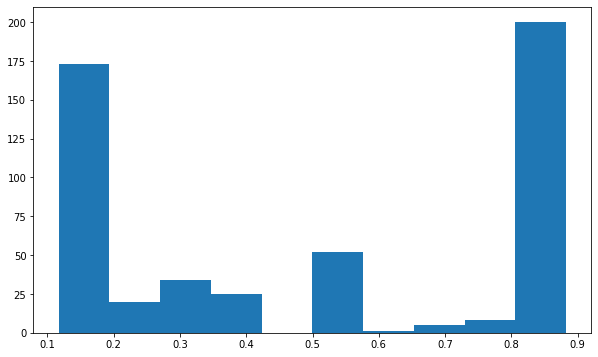

In [119]:
plt.hist(probsdf_test['GBprobs_0'])

In [120]:
dat = corr_analysis['trth'].to_numpy()

In [121]:
zz = corr_analysis.index

<BarContainer object of 7 artists>

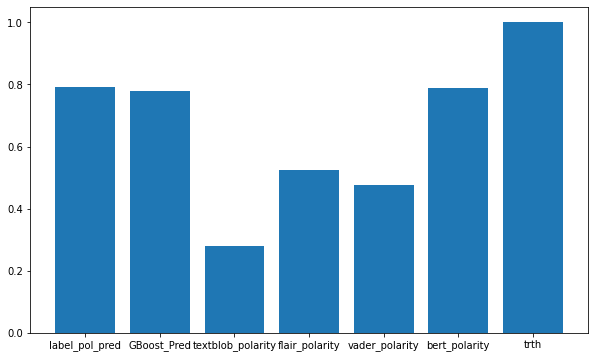

In [122]:

matplotlib.pyplot.bar(zz,dat)

In [123]:
zz.to_list()

['label_pol_pred',
 'GBoost_Pred',
 'textblob_polarity',
 'flair_polarity',
 'vader_polarity',
 'bert_polarity',
 'trth']

In [124]:
dat

array([0.7901178 , 0.78002226, 0.27832333, 0.52580819, 0.47466545,
       0.78791397, 1.        ])

# Final Analysis LR vs GBoost

In [125]:
alpha_th_test = 0
pd.DataFrame(metrics.classification_report(probsdf_test['trth'][(probsdf_test['GBprobs_1']>alpha_th_test) | (probsdf_test['GBprobs_0']>alpha_th_test)],probsdf_test['GBoost_Pred'][(probsdf_test['GBprobs_1']>alpha_th_test) | (probsdf_test['GBprobs_0']>alpha_th_test)],output_dict=True))

,-1,1,accuracy,macro avg,weighted avg
precision,0.883459,0.896825,0.889961,0.890142,0.890090
recall,0.900383,0.879377,0.889961,0.889880,0.889961
f1-score,0.891841,0.888016,0.889961,0.889928,0.889943
support,261.000000,257.000000,0.889961,518.000000,518.000000


In [126]:
alpha_th_test = 0
pd.DataFrame(metrics.classification_report(probsdf_test['trth'][(probsdf_test[0]>alpha_th_test) | (probsdf_test[1]>alpha_th_test)],probsdf_test['label_pol_pred'][(probsdf_test[0]>alpha_th_test) | (probsdf_test[1]>alpha_th_test)],output_dict=True))

,-1,1,accuracy,macro avg,weighted avg
precision,0.963636,0.835570,0.889961,0.899603,0.900098
recall,0.812261,0.968872,0.889961,0.890566,0.889961
f1-score,0.881497,0.897297,0.889961,0.889397,0.889336
support,261.000000,257.000000,0.889961,518.000000,518.000000


In [127]:
probsdf_test.head()

,0,1,trth,label_pol_pred,tb,vader,bert,flair,textblob_polarity,vader_polarity,bert_polarity,flair_polarity,GBprobs_0,GBprobs_1,GBoost_polarity,GBoost_Pred,trth1
0,0.581587,0.418413,1,1,0.0000,0.0000,0.000000,-0.998799,1.0,1.0,1.0,-1.0,0.505568,0.494432,-1,-1,NaN
1,0.960170,0.039830,-1,-1,-0.0258,-0.0258,-0.737471,-0.994933,1.0,-1.0,-1.0,-1.0,0.880427,0.119573,-1,-1,NaN
2,0.583993,0.416007,1,1,0.0129,0.0129,0.000000,-0.755804,1.0,1.0,1.0,-1.0,0.367719,0.632281,1,1,-1.0
3,0.971582,0.028418,-1,-1,-0.5334,-0.5334,-0.806515,-0.981972,1.0,-1.0,-1.0,-1.0,0.882273,0.117727,-1,-1,1.0
4,0.023527,0.976473,1,1,0.5859,0.5859,0.758257,0.969718,1.0,1.0,1.0,1.0,0.117424,0.882576,1,1,1.0


In [128]:
semeval_vader_acc = pd.DataFrame(metrics.classification_report(dataset_analysis['Sentiment'], dataset_analysis['vader_polarity'],output_dict=True))
semeval_tb_acc = pd.DataFrame(metrics.classification_report(dataset_analysis['Sentiment'], dataset_analysis['textblob_polarity'],output_dict=True))
semeval_bert_acc = pd.DataFrame(metrics.classification_report(dataset_analysis['Sentiment'], dataset_analysis['bert_polarity'],output_dict=True))
semeval_flair_acc = pd.DataFrame(metrics.classification_report(dataset_analysis['Sentiment'], dataset_analysis['flair_polarity'],output_dict=True))

alpha_th_test = 0
semeval_gboost_acc = pd.DataFrame(metrics.classification_report(probsdf_test['trth'][(probsdf_test['GBprobs_1']>alpha_th_test) | (probsdf_test['GBprobs_0']>alpha_th_test)],probsdf_test['GBoost_Pred'][(probsdf_test['GBprobs_1']>alpha_th_test) | (probsdf_test['GBprobs_0']>alpha_th_test)],output_dict=True))
semeval_LR_acc = pd.DataFrame(metrics.classification_report(probsdf_test['trth'][(probsdf_test[0]>alpha_th_test) | (probsdf_test[1]>alpha_th_test)],probsdf_test['label_pol_pred'][(probsdf_test[0]>alpha_th_test) | (probsdf_test[1]>alpha_th_test)],output_dict=True))
semeval_acc_compare = pd.DataFrame({'Dataset':'semeval','Log_reg_meta':[0],'GBoost_meta':[0],'VADER':[0],'TextBlob':[0],'Flair':[0],'BERT':[0]})
semeval_acc_compare['GBoost_meta'].iloc[0]=semeval_gboost_acc['accuracy'].loc['precision']
semeval_acc_compare['Log_reg_meta'].iloc[0]=semeval_LR_acc['accuracy'].loc['precision']
semeval_acc_compare['VADER'].iloc[0]=semeval_vader_acc['accuracy'].loc['precision']
semeval_acc_compare['BERT'].iloc[0]=semeval_bert_acc['accuracy'].loc['precision']
semeval_acc_compare['Flair'].iloc[0]=semeval_flair_acc['accuracy'].loc['precision']
semeval_acc_compare['TextBlob'].iloc[0]=semeval_tb_acc['accuracy'].loc['precision']
semeval_acc_compare.to_csv('semeval_acc_analysis.csv')
semeval_acc_compare

/Users/amitobe/opt/anaconda3/envs/nlp_course/lib/python3.7/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,Dataset,Log_reg_meta,GBoost_meta,VADER,TextBlob,Flair,BERT
0,semeval,0.889961,0.889961,0.706837,0.617613,0.761298,0.874855


## SemEval 2017 Test Data Analysis
Here we found that this dataset is the same as the original dataset 
So below we test the Log Regressor on the entire ensemble and see results once again
We find consistent accuraccy

In [129]:
probsdf_test


,0,1,trth,label_pol_pred,tb,vader,bert,flair,textblob_polarity,vader_polarity,bert_polarity,flair_polarity,GBprobs_0,GBprobs_1,GBoost_polarity,GBoost_Pred,trth1
0,0.581587,0.418413,1,1,0.0000,0.0000,0.000000,-0.998799,1.0,1.0,1.0,-1.0,0.505568,0.494432,-1,-1,NaN
1,0.960170,0.039830,-1,-1,-0.0258,-0.0258,-0.737471,-0.994933,1.0,-1.0,-1.0,-1.0,0.880427,0.119573,-1,-1,NaN
2,0.583993,0.416007,1,1,0.0129,0.0129,0.000000,-0.755804,1.0,1.0,1.0,-1.0,0.367719,0.632281,1,1,-1.0
3,0.971582,0.028418,-1,-1,-0.5334,-0.5334,-0.806515,-0.981972,1.0,-1.0,-1.0,-1.0,0.882273,0.117727,-1,-1,1.0
4,0.023527,0.976473,1,1,0.5859,0.5859,0.758257,0.969718,1.0,1.0,1.0,1.0,0.117424,0.882576,1,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
513,0.973946,0.026054,-1,-1,-0.3612,-0.3612,-0.876151,-0.998469,-1.0,-1.0,-1.0,-1.0,0.882273,0.117727,-1,-1,NaN
514,0.979776,0.020224,-1,-1,-0.4003,-0.4003,-0.952544,-0.998901,-1.0,-1.0,-1.0,-1.0,0.882273,0.117727,-1,-1,NaN
515,0.966139,0.033861,-1,-1,-0.4158,-0.4158,-0.804400,-0.935471,-1.0,-1.0,-1.0,-1.0,0.882273,0.117727,-1,-1,NaN
516,0.973574,0.026426,-1,-1,0.3818,0.3818,-0.934049,-0.999993,1.0,1.0,-1.0,-1.0,0.882273,0.117727,-1,-1,NaN


# Ensemble Select

In [202]:
from sklearn.metrics import accuracy_score

In [152]:
from itertools import combinations

# List of base models (replace with your actual base models)
base_models = ['vader','textblob','bert','flair']

# Generate all possible combinations of base models
ensemble_combinations = []
for r in range(1, len(base_models) + 1):
    ensemble_combinations.extend(combinations(base_models, r))

# Store each ensemble as a list
ensembles = []
for combination in ensemble_combinations:
    ensembles.append(np.array(combination))

# Print the generated ensembles
for idx, ensemble in enumerate(ensembles, start=1):
    print(f"Ensemble {idx}: {ensemble}")



Ensemble 1: ['vader']
Ensemble 2: ['textblob']
Ensemble 3: ['bert']
Ensemble 4: ['flair']
Ensemble 5: ['vader' 'textblob']
Ensemble 6: ['vader' 'bert']
Ensemble 7: ['vader' 'flair']
Ensemble 8: ['textblob' 'bert']
Ensemble 9: ['textblob' 'flair']
Ensemble 10: ['bert' 'flair']
Ensemble 11: ['vader' 'textblob' 'bert']
Ensemble 12: ['vader' 'textblob' 'flair']
Ensemble 13: ['vader' 'bert' 'flair']
Ensemble 14: ['textblob' 'bert' 'flair']
Ensemble 15: ['vader' 'textblob' 'bert' 'flair']


In [220]:
X = our_data[['textblob','vader','bert','flair','vader_polarity','textblob_polarity','bert_polarity','flair_polarity','Sentiment']]
y = our_data['Sentiment']
acc_sc_en = []
ens = []
logmodel1 = LogisticRegression()
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3)
X_t = X_train
X_te = X_test
y_t = y_train
y_te = y_test
for i in range(15):
    X_train = X_t[ensembles[i]]
    X_test = X_te[ensembles[i]]
    y_train = y_t
    y_test = y_te
    X_train = mmscaler.fit_transform(X_train)
    X_test = mmscaler.fit_transform(X_test)
    logmodel1.fit(X_train,y_train)
    preds = logmodel1.predict(X_test)
    acc_ensemble = accuracy_score(y_test,preds)
    print (ensembles[i])
    print(acc_ensemble)
    acc_sc_en.append(acc_ensemble)
    ens.append(ensembles[i])

['vader']
0.6525096525096525
['textblob']
0.6332046332046332
['bert']
0.8706563706563707
['flair']
0.7335907335907336
['vader' 'textblob']
0.6602316602316602
['vader' 'bert']
0.8783783783783784
['vader' 'flair']
0.747104247104247
['textblob' 'bert']
0.8725868725868726
['textblob' 'flair']
0.7297297297297297
['bert' 'flair']
0.8687258687258688
['vader' 'textblob' 'bert']
0.8745173745173745
['vader' 'textblob' 'flair']
0.750965250965251
['vader' 'bert' 'flair']
0.8725868725868726
['textblob' 'bert' 'flair']
0.8687258687258688
['vader' 'textblob' 'bert' 'flair']
0.8725868725868726


In [221]:
acc_sc_en

[0.6525096525096525,
 0.6332046332046332,
 0.8706563706563707,
 0.7335907335907336,
 0.6602316602316602,
 0.8783783783783784,
 0.747104247104247,
 0.8725868725868726,
 0.7297297297297297,
 0.8687258687258688,
 0.8745173745173745,
 0.750965250965251,
 0.8725868725868726,
 0.8687258687258688,
 0.8725868725868726]

In [222]:
ens

[array(['vader'], dtype='<U5'),
 array(['textblob'], dtype='<U8'),
 array(['bert'], dtype='<U4'),
 array(['flair'], dtype='<U5'),
 array(['vader', 'textblob'], dtype='<U8'),
 array(['vader', 'bert'], dtype='<U5'),
 array(['vader', 'flair'], dtype='<U5'),
 array(['textblob', 'bert'], dtype='<U8'),
 array(['textblob', 'flair'], dtype='<U8'),
 array(['bert', 'flair'], dtype='<U5'),
 array(['vader', 'textblob', 'bert'], dtype='<U8'),
 array(['vader', 'textblob', 'flair'], dtype='<U8'),
 array(['vader', 'bert', 'flair'], dtype='<U5'),
 array(['textblob', 'bert', 'flair'], dtype='<U8'),
 array(['vader', 'textblob', 'bert', 'flair'], dtype='<U8')]

In [246]:
result_ensembles = pd.DataFrame(ens)

In [247]:
result_ensembles['Accuracy_semeval']=acc_sc_en

In [248]:
result_ensembles.sort_values(by = 'Accuracy_semeval',ascending=False)

,0,1,2,3,Accuracy_semeval
5,vader,bert,None,None,0.878378
10,vader,textblob,bert,None,0.874517
7,textblob,bert,None,None,0.872587
12,vader,bert,flair,None,0.872587
14,vader,textblob,bert,flair,0.872587
2,bert,None,None,None,0.870656
9,bert,flair,None,None,0.868726
13,textblob,bert,flair,None,0.868726
11,vader,textblob,flair,None,0.750965
6,vader,flair,None,None,0.747104


In [249]:
def concatenate_columns(row):
    non_null_values = [str(val) for val in row if not pd.isnull(val)]
    return ', '.join(non_null_values)

result_ensembles['Ensemble'] = result_ensembles[[0,1,2,3]].apply(concatenate_columns, axis=1)

In [250]:
result_ensembles

,0,1,2,3,Accuracy_semeval,Ensemble
0,vader,None,None,None,0.652510,vader
1,textblob,None,None,None,0.633205,textblob
2,bert,None,None,None,0.870656,bert
3,flair,None,None,None,0.733591,flair
4,vader,textblob,None,None,0.660232,"vader, textblob"
5,vader,bert,None,None,0.878378,"vader, bert"
6,vader,flair,None,None,0.747104,"vader, flair"
7,textblob,bert,None,None,0.872587,"textblob, bert"
8,textblob,flair,None,None,0.729730,"textblob, flair"
9,bert,flair,None,None,0.868726,"bert, flair"


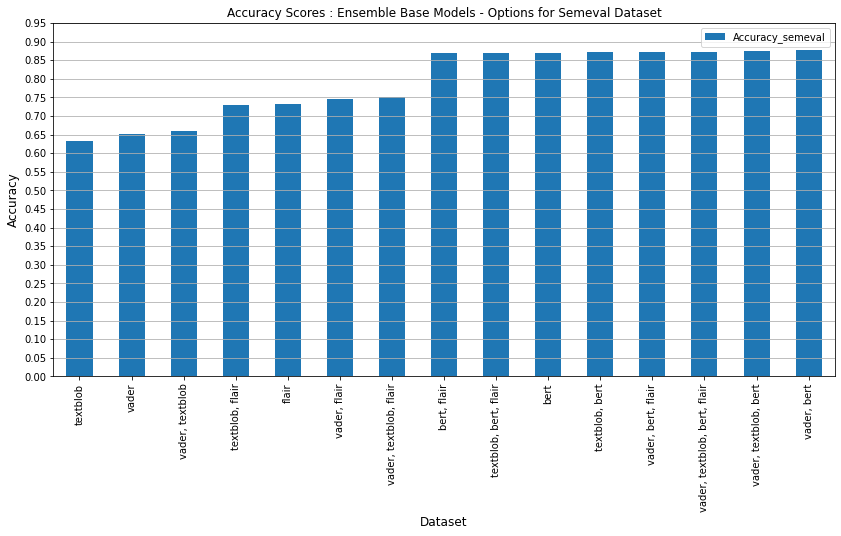

In [258]:
ax = result_ensembles.sort_values(by="Accuracy_semeval").plot(x="Ensemble", y=["Accuracy_semeval"],kind="bar",figsize=(14,6.5))
#ax.legend(["Log_reg_meta","GBoost_meta","VADER","TextBlob","Flair","BERT"],loc = 'upper left',fontsize=11)
ax.set_xlabel('Dataset', fontsize=12)  # Change label and font size
ax.set_ylabel('Accuracy', fontsize=12)  # Change label and font size
ax.set_title('Accuracy Scores : Ensemble Base Models - Options for Semeval Dataset')
y_ticks = [(i*.05) for i in range(0,20)]
ax.set_yticks(y_ticks)
ax.yaxis.grid(True)
# Increase font size of tick labels

